In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot_subject_levels

In [2]:
df = pd.read_csv(r'/workspaces/miniconda/PKdata/data-raw/KI20160914/KI20160914.csv')
#df = pd.read_csv(r'/workspaces/miniconda/PK-Analysis/gem_toy_data.csv')
df = df.loc[df['TIME'] != 0.5, :].reset_index()
df['DAY'] = 1

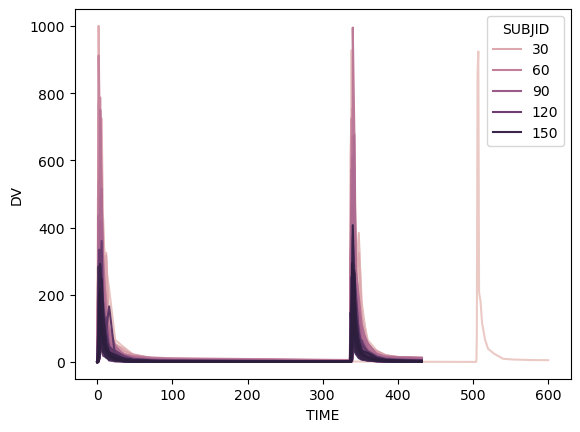

In [3]:
plot_subject_levels(df)

In [4]:
from scipy.integrate import solve_ivp
import numpy as np
from tqdm import tqdm
from utils import one_compartment_model, objective_function

In [5]:
#prepare day 1 data
opt_df = df.dropna(subset = 'DV').copy()
opt_df['DV'] = opt_df['DV'].astype(pd.Float32Dtype())
opt_df = opt_df.loc[opt_df['DAY'] == 1, :]

#Within day 1 data, per subject identify the max concentration
#Drop time points occuring before the max, and set the time at that max conc to t=0
dfs = []
for c in opt_df['SUBJID'].drop_duplicates():
    work_df = opt_df.loc[opt_df['SUBJID'] == c, :].reset_index(drop = True)
    max_idx = work_df.loc[work_df['DV'] == work_df['DV'].max(), :].index[0]
    work_df = work_df.iloc[max_idx:, :]
    work_df['TIME'] = work_df['TIME'] - work_df['TIME'].min()
    dfs.append(work_df.copy())
work_df = pd.concat(dfs)

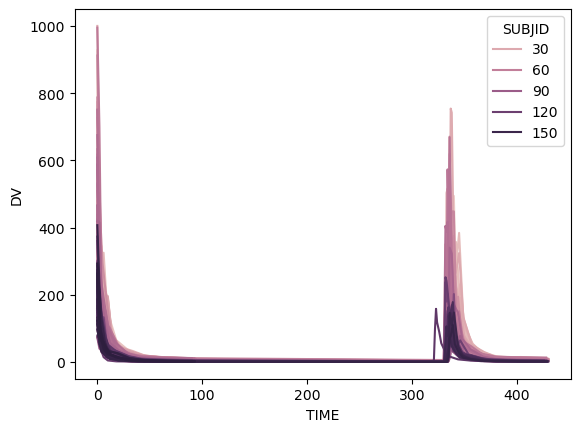

In [6]:
#plot the prepared data
plot_subject_levels(work_df)

In [7]:
import numpy as np
from scipy.optimize import minimize
from joblib import dump, load
import os
from functools import partial
from utils import optimize_with_checkpoint_joblib

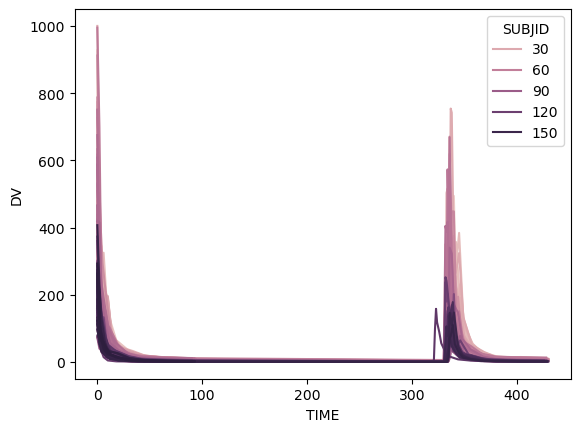

In [8]:
from sklearn.preprocessing import RobustScaler
scale_df = work_df.copy()
#scale_df[['DV']] = RobustScaler().fit_transform(scale_df[['DV']])
mgkg_scaler = RobustScaler()
age_scaler = RobustScaler()
wt_scaler = RobustScaler()

#scale_df['MGKG'] = (scale_df['DOSR'] / scale_df['WT'])
scale_df['WT_scale'] = wt_scaler.fit_transform(scale_df[['WT']])
#scale_df['MGKG_scale'] = mgkg_scaler.fit_transform(scale_df[['MGKG']])
scale_df['AGE_scale'] = age_scaler.fit_transform(scale_df[['AGE']])
#scale_df['DOSR'] = scale_df['DOSR'] / 100
plot_subject_levels(scale_df)

In [9]:
from sklearn.metrics import auc


sub0 = scale_df.loc[scale_df['SUBJID'] == 1.0, :]
sub0

,index,SUBJID,VIST,DAY,TIME,NTPD,DOSR,AMT,DV,FORM,TRTCD,SEX,AGE,WT,WT_scale,AGE_scale
21,24.0,1.0,2.0,1.0,0.0,6.0,300.0,NaN,574.0,1.0,B,1.0,26.0,84.0,0.3125,0.071429
22,25.0,1.0,2.0,1.0,2.0,8.0,300.0,NaN,166.0,1.0,B,1.0,26.0,84.0,0.3125,0.071429
23,26.0,1.0,2.0,1.0,6.0,12.0,300.0,NaN,66.5,1.0,B,1.0,26.0,84.0,0.3125,0.071429
24,27.0,1.0,2.0,1.0,10.0,16.0,300.0,NaN,44.900002,1.0,B,1.0,26.0,84.0,0.3125,0.071429
25,28.0,1.0,2.0,1.0,18.0,24.0,300.0,NaN,25.1,1.0,B,1.0,26.0,84.0,0.3125,0.071429
26,29.0,1.0,2.0,1.0,30.0,36.0,300.0,NaN,10.2,1.0,B,1.0,26.0,84.0,0.3125,0.071429
27,30.0,1.0,2.0,1.0,42.0,48.0,300.0,NaN,8.15,1.0,B,1.0,26.0,84.0,0.3125,0.071429
28,31.0,1.0,2.0,1.0,66.0,72.0,300.0,NaN,4.86,1.0,B,1.0,26.0,84.0,0.3125,0.071429
29,32.0,1.0,2.0,1.0,90.0,96.0,300.0,NaN,3.92,1.0,B,1.0,26.0,84.0,0.3125,0.071429


In [10]:
from functools import partial
from sklearn.preprocessing import RobustScaler
def calculate_auc_clearance(group_df, x, y, dose):
  """Calculates AUC for a DataFrame group.

  Args:
    group_df: A Pandas DataFrame with 'x' and 'y' columns.

  Returns:
    The AUC score.
  """
  # Sort by x to ensure correct AUC calculation
  group_df = group_df.sort_values(x)
  auc_val = auc(group_df[x], group_df[y])
  return group_df[dose].values[0] / auc_val
auc_func = partial(calculate_auc_clearance, x = 'TIME', y = 'DV', dose = 'DOSR')
auc_scaler = RobustScaler()
aucs = scale_df[['SUBJID', 'TIME', 'DV', 'DOSR']].groupby('SUBJID').apply(auc_func)
#aucs_scale = auc_scaler.fit_transform(aucs.reset_index()[[0]])

/tmp/ipykernel_18020/3295190261.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aucs = scale_df[['SUBJID', 'TIME', 'DV', 'DOSR']].groupby('SUBJID').apply(auc_func)


2025-01-30 19:10:40.293 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-01-30 19:10:40.449 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=7603.747045)
2025-01-30 19:10:40.468 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted beta distribution with error=2205.66473)
2025-01-30 19:10:40.522 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted bradford distribution with error=3750.725457)
2025-01-30 19:10:40.535 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3229.4723)
2025-01-30 19:10:40.568 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=2330.759008)
2025-01-30 19:10:40.579 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=5954.533923)
2025-01-30 19:10:40.649 | INFO     | fitter.fitter:_fit_single_dist

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
laplace_asymmetric,1504.815255,-185.886834,-176.680121,inf,0.073201,3.449216e-01
genhyperbolic,1509.993727,-180.785609,-165.441088,inf,0.660436,1.282850e-68
skewcauchy,1599.620625,-156.863671,-147.656958,inf,0.115844,2.576680e-02
exponnorm,1631.886723,-187.501834,-178.295121,inf,0.075143,3.146816e-01
wald,1839.855378,-212.742560,-206.604751,inf,0.066931,4.549469e-01


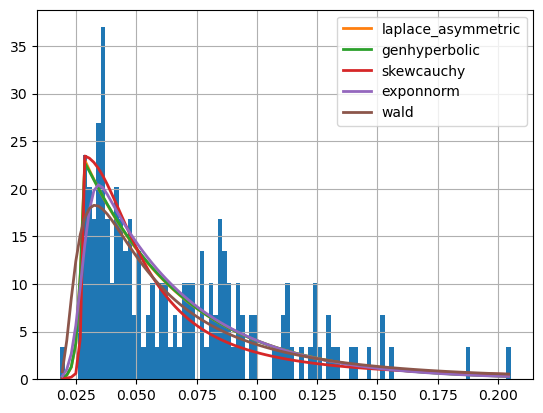

In [11]:
from fitter import Fitter

f = Fitter(aucs.values)
f.fit()
f.summary()

In [12]:
f.fitted_param['skewcauchy']

(0.9656883303830518, 0.0276888675449516, 0.013557548879029126)

In [ ]:
from scipy import stats
data = stats.skewcauchy.rvs(2, loc=1.5, scale=2, size=100000)

In [ ]:
import pymc as pm

with pm.Model() as auc_mod:
    auc1 = pm.Normal

<Axes: ylabel='Density'>

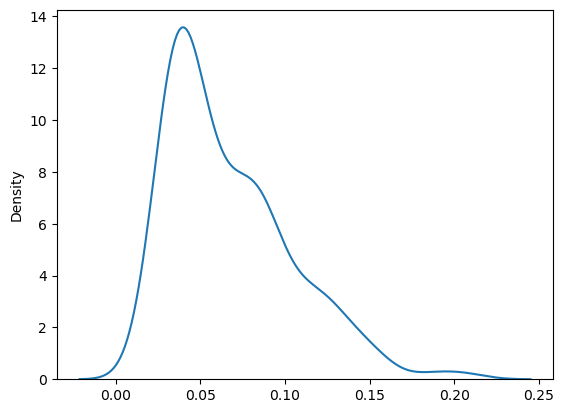

In [34]:
import seaborn as sns

sns.kdeplot(aucs)

In [11]:
auc(sub0['TIME'].values, sub0['DV'].values)

2291.1800079345703

In [10]:
from utils import OneCompartmentModel, ObjectiveFunctionColumn
mod_sse = OneCompartmentModel(dep_vars= {'k':[ ],
                                           'vd':[]}, 
                              #loss_function=sum_of_squares_loss, 
                              optimizer_tol=None
                              )
mod_sse_param = OneCompartmentModel(dep_vars= {'k':[ ObjectiveFunctionColumn('AGE_scale'),
                                                ObjectiveFunctionColumn('SEX' )],
                                           'vd':[ObjectiveFunctionColumn('WT_scale',
                                                                         model_method='linear',
                                                                         
                                                                         allometric_norm_value=wt_scaler.transform([[70]])[0][0], 
                                                                         
                                                                         )]}, 
                              #loss_function=sum_of_squares_loss, 
                              optimizer_tol=None
                              )

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [11]:
init_summary = mod_sse.init_vals_pd

In [12]:
import pymc as pm

In [13]:
model_params = init_summary.loc[init_summary['population_coeff'], :]
model_params

,model_coeff,model_coeff_dep_var,population_coeff,init_val,allometric,allometric_norm_value
0,k,None,True,-0.510826,False,None
1,vd,None,True,0.693147,False,None


In [14]:
model_param_dep_vars = init_summary.loc[init_summary['population_coeff'] == False, :]
model_param_dep_vars

,model_coeff,model_coeff_dep_var,population_coeff,init_val,allometric,allometric_norm_value


In [15]:
print(f"model_params = pd.DataFrame({model_params.to_dict()})")

model_params = pd.DataFrame({'model_coeff': {0: 'k', 1: 'vd'}, 'model_coeff_dep_var': {0: None, 1: None}, 'population_coeff': {0: True, 1: True}, 'init_val': {0: -0.5108256237659907, 1: 0.6931471805599453}, 'allometric': {0: False, 1: False}, 'allometric_norm_value': {0: None, 1: None}})


In [16]:
print(f"model_param_dep_vars = pd.DataFrame({model_param_dep_vars.to_dict()})")

model_param_dep_vars = pd.DataFrame({'model_coeff': {}, 'model_coeff_dep_var': {}, 'population_coeff': {}, 'init_val': {}, 'allometric': {}, 'allometric_norm_value': {}})


In [17]:
model_param_dep_vars.to_dict()

{'model_coeff': {},
 'model_coeff_dep_var': {},
 'population_coeff': {},
 'init_val': {},
 'allometric': {},
 'allometric_norm_value': {}}

In [18]:
def one_compartment_model(t, y, theta ):
    """
    Defines the differential equation for a one-compartment pharmacokinetic model.

    This function calculates the rate of change of drug concentration in the central 
    compartment over time.

    Args:
      t (float): Time point (not used in this specific model, but required by solve_ivp).
      y (list): Current drug concentration in the central compartment.
      k (float): Elimination rate constant.
      Vd (float): Volume of distribution.


    Returns:
      float: The rate of change of drug concentration (dC/dt).
    """
    k, Vd = theta
    C = y[0]  # Extract concentration from the state vector
    dCdt = -(k/Vd) * C  # Calculate the rate of change
    return dCdt

In [19]:
from pytensor.compile.ops import as_op
import pytensor.tensor as pt
import pytensor
from scipy.integrate import solve_ivp
import os

# Set PyTensor flags for debugging
os.environ["PYTENSOR_FLAGS"] = "optimizer=fast_compile,exception_verbosity=high"

In [20]:
work_df

,index,Unnamed: 0,SUBJID,TIME,DV,k_pop,vd_pop,k_i,vd_i,y0_i,AGE,WT,SEX,DAY
0,0.0,0.0,1.0,0.0,0.88852,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0
1,2.0,2.0,1.0,1.0,0.835347,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0
2,3.0,3.0,1.0,2.0,0.838159,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0
3,4.0,4.0,1.0,6.0,0.656203,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0
4,5.0,5.0,1.0,8.0,0.385562,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0
5,6.0,6.0,1.0,12.0,0.257812,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0
6,7.0,7.0,1.0,18.0,0.09012,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0
0,8.0,8.0,2.0,0.0,1.370865,0.5,3.0,0.448338,2.188400,1.370865,30.0,87.494227,1.0,1.0
1,10.0,10.0,2.0,1.0,1.240741,0.5,3.0,0.448338,2.188400,1.370865,30.0,87.494227,1.0,1.0
2,11.0,11.0,2.0,2.0,1.115355,0.5,3.0,0.448338,2.188400,1.370865,30.0,87.494227,1.0,1.0


In [21]:
#needed_idx = scale_df['TIME'].value_counts()[:10].index.values
scale_df_filter = []
for sub in scale_df['SUBJID'].unique():
    work_df = scale_df.loc[scale_df['SUBJID'] == sub, :].copy()
    tp = work_df['TIME'].values[:10]
    work_df = work_df.loc[work_df['TIME'].isin(tp), :]
    #nrows = len(work_df)
    #if nrows == len(needed_idx):
    scale_df_filter.append(work_df.copy())
scale_df_filter = pd.concat(scale_df_filter)
    

In [22]:
debug_df = scale_df.loc[scale_df['SUBJID'].isin([1, 2]), :]
debug_df = debug_df.loc[(debug_df['TIME'] < 30) & (debug_df['TIME'] != 3), :]

In [23]:
debug_df = scale_df_filter.copy()
debug_df = debug_df.loc[debug_df['SUBJID'].isin([1, 2]), :]

In [24]:
all_subject_data = debug_df[['SUBJID', 'AGE_scale', 'WT_scale', 'SEX', 'DV']].drop_duplicates(subset = 'SUBJID', keep='first').copy()

In [25]:
pm_df = debug_df.copy().reset_index(drop = True)
pm_subj_df = all_subject_data.copy().reset_index(drop = True)

In [26]:
tps = pm_df.groupby('SUBJID')['TIME'].unique().reset_index().rename(columns = {'TIME':'subj_tp'})
tps_min = pm_df.groupby('SUBJID')['TIME'].min().reset_index().rename(columns = {'TIME':'subj_tp_min'})
tps_max = pm_df.groupby('SUBJID')['TIME'].max().reset_index().rename(columns = {'TIME':'subj_tp_max'})

In [27]:
pm_subj_df = (pm_subj_df.merge(tps, how = 'left', on = 'SUBJID')
                    .merge(tps_min, how = 'left', on = 'SUBJID')
                    .merge(tps_max, how = 'left', on = 'SUBJID')
                    
                    )

In [28]:
import logging

# Configure logging to capture console output
logging.basicConfig(filename='pymc_debug.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [29]:
pm_df['tmp'] = 1
time_mask_df = pm_df.pivot( index = 'SUBJID', columns = 'TIME', values = 'tmp').fillna(0)
time_mask = time_mask_df.to_numpy().astype(bool)
all_sub_tp_alt = pm_df.pivot( index = 'SUBJID', columns = 'TIME', values = 'TIME')

In [30]:
all_sub_tp = np.tile(all_sub_tp_alt.columns, (len(time_mask_df),1)).shape

In [31]:
all_sub_tp

(2, 8)

In [32]:
coords = {'subject':list(pm_subj_df['SUBJID'].values), 
          'obs_id': list(pm_df.index.values)
          }

In [33]:
max_time_points = pm_subj_df['subj_tp'].apply(len).max()
all_subject_tps = np.full((len(coords['subject']), max_time_points), -1.0)
time_mask = np.zeros((len(coords['subject']), max_time_points), dtype=bool)

In [34]:
pm_subj_df['subj_tp'].apply(len).max()

7

In [35]:
pm_df

,index,Unnamed: 0,SUBJID,TIME,DV,k_pop,vd_pop,k_i,vd_i,y0_i,AGE,WT,SEX,DAY,WT_scale,AGE_scale,tmp
0,0.0,0.0,1.0,0.0,0.88852,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0,-0.839199,0.0,1
1,2.0,2.0,1.0,1.0,0.835347,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0,-0.839199,0.0,1
2,3.0,3.0,1.0,2.0,0.838159,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0,-0.839199,0.0,1
3,4.0,4.0,1.0,6.0,0.656203,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0,-0.839199,0.0,1
4,5.0,5.0,1.0,8.0,0.385562,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0,-0.839199,0.0,1
5,6.0,6.0,1.0,12.0,0.257812,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0,-0.839199,0.0,1
6,7.0,7.0,1.0,18.0,0.09012,0.5,3.0,0.483581,3.376402,0.888520,34.0,75.800597,0.0,1.0,-0.839199,0.0,1
7,8.0,8.0,2.0,0.0,1.370865,0.5,3.0,0.448338,2.188400,1.370865,30.0,87.494227,1.0,1.0,0.000000,-2.0,1
8,10.0,10.0,2.0,1.0,1.240741,0.5,3.0,0.448338,2.188400,1.370865,30.0,87.494227,1.0,1.0,0.000000,-2.0,1
9,11.0,11.0,2.0,2.0,1.115355,0.5,3.0,0.448338,2.188400,1.370865,30.0,87.494227,1.0,1.0,0.000000,-2.0,1


In [36]:
from pymc_utils import make_pymc_model

model = make_pymc_model(pm_subj_df, pm_df, model_params, model_param_dep_vars)

Shape of coeff_intercept_i[k]: [2]
Shape of coeff_intercept_i[vd]: [2]
Shape of intial conc: (2,)
Shape of subject min tp: [2]
Shape of subject max tp: [2]
Shape of theta_matrix: (2, 2)
Shape of tp_data: (2, 8)
Shape of tp_data[0,:]: (8,)
[]
[2]
Shape.0
[]
[]
[8]
[]
[2]
Shape.0
[]
[]
[8]
[16]
[14]


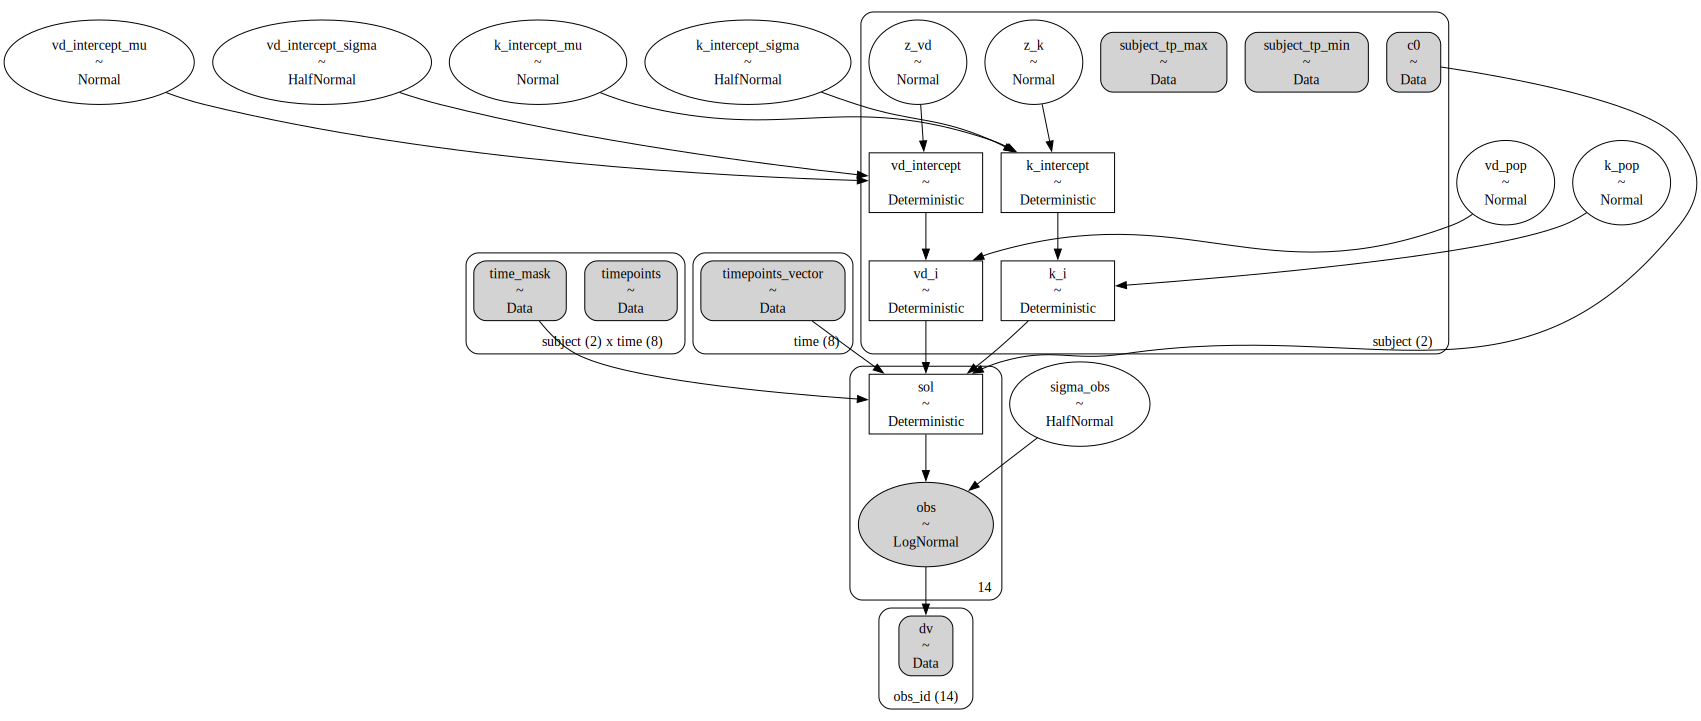

In [37]:
pm.model_to_graphviz(model)

In [38]:
list(model.values_to_rvs.keys())[:-1]

[k_pop,
 k_intercept_mu,
 k_intercept_sigma_log__,
 z_k,
 vd_pop,
 vd_intercept_mu,
 vd_intercept_sigma_log__,
 z_vd,
 sigma_obs_log__]

In [ ]:
vars_list = list(model.values_to_rvs.keys())[:-1]

sampler = "DEMetropolisZ"
tune = 5000
draws = 5000
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], cores = 1, tune = tune, draws = draws)


Sequential sampling (2 chains in 1 job)
DEMetropolisZ: [k_pop, k_intercept_mu, k_intercept_sigma, z_k, vd_pop, vd_intercept_mu, vd_intercept_sigma, z_vd, sigma_obs]


Output()

In [41]:
np.exp(trace_DEMZ)

TypeError: ufunc 'exp' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [40]:
print(trace_DEMZ.posterior["sol"].shape)

(1, 1, 20)


In [42]:
trace_DEMZ

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [45]:
trace_DEMZ.posterior.sol[0][0][:,0]

<xarray.DataArray 'sol' (sol_dim_0: 20)> Size: 160B
array([ 275.        ,  274.50094604,  273.00338745,  270.50762939,
        262.52120972,  250.54148865,  214.60253906,  162.69056702,
         10.94802856, -336.46200562,  625.        ,  624.50067139,
        623.00128174,  617.00488281,  607.01165771,  575.03234863,
        527.06335449,  383.15679932,   47.37372971, -432.31448364])
Coordinates:
    chain      int64 8B 0
    draw       int64 8B 0
  * sol_dim_0  (sol_dim_0) int64 160B 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    sol_dim_1  int64 8B 0

In [41]:
trace_DEMZ

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'k_pop'}>,
        <Axes: title={'center': 'k_pop'}>],
       [<Axes: title={'center': 'k_intercept_mu'}>,
        <Axes: title={'center': 'k_intercept_mu'}>],
       [<Axes: title={'center': 'z_k'}>, <Axes: title={'center': 'z_k'}>],
       [<Axes: title={'center': 'vd_pop'}>,
        <Axes: title={'center': 'vd_pop'}>],
       [<Axes: title={'center': 'vd_intercept_mu'}>,
        <Axes: title={'center': 'vd_intercept_mu'}>],
       [<Axes: title={'center': 'z_vd'}>,
        <Axes: title={'center': 'z_vd'}>],
       [<Axes: title={'center': 'k_intercept_sigma'}>,
        <Axes: title={'center': 'k_intercept_sigma'}>],
       [<Axes: title={'center': 'vd_intercept_sigma'}>,
        <Axes: title={'center': 'vd_intercept_sigma'}>],
       [<Axes: title={'center': 'sigma_obs'}>,
        <Axes: title={'center': 'sigma_obs'}>],
       [<Axes: title={'center': 'k_intercept'}>,
        <Axes: title={'center': 'k_intercept'}>],
       [<Axes: title={'center': 'k

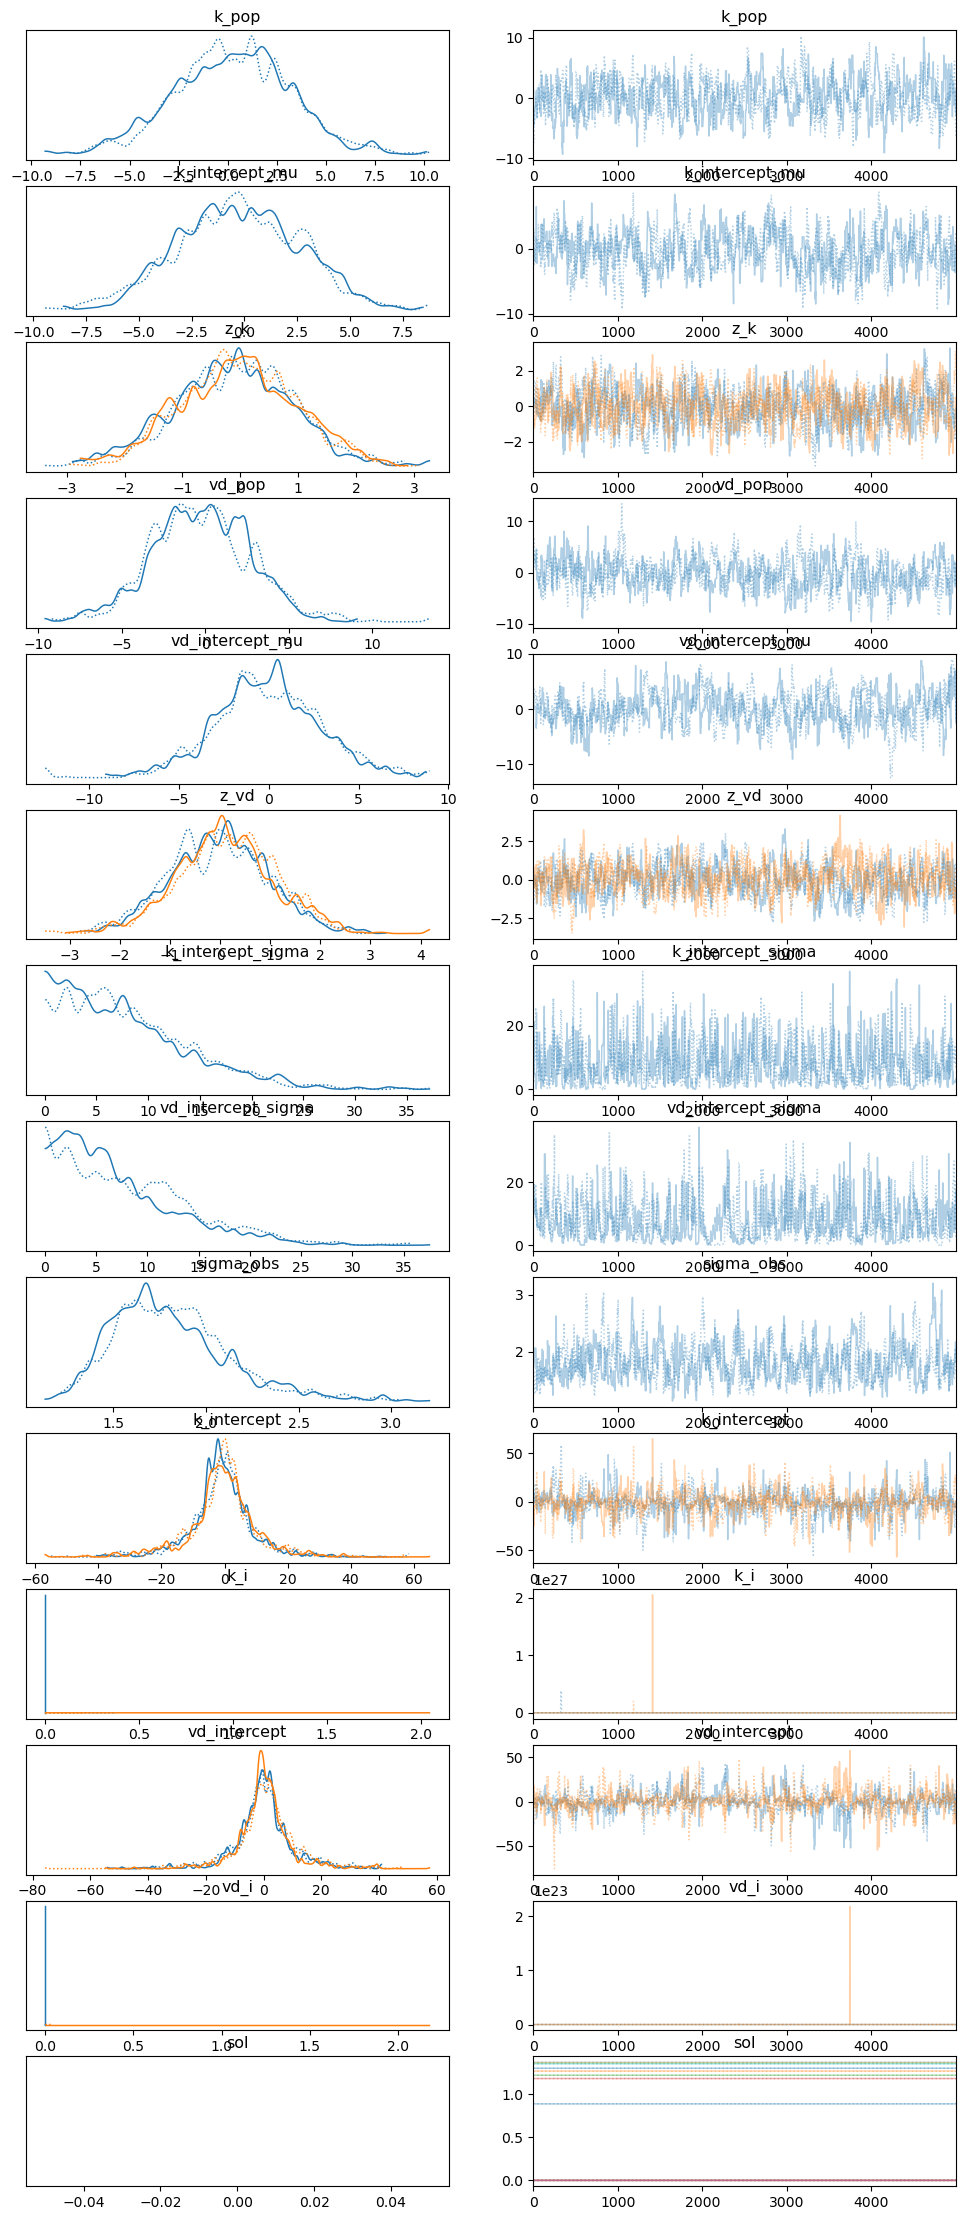

In [43]:
import arviz as az
az.plot_trace(trace_DEMZ)

In [44]:
import arviz as az
az.summary(trace_DEMZ)

/opt/conda/envs/pySunODE/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k_pop,2.700000e-01,2.912000e+00,-5.266,5.722000e+00,1.740000e-01,1.230000e-01,280.0,593.0,1.01
k_intercept_mu,-2.810000e-01,2.883000e+00,-5.631,4.832000e+00,1.870000e-01,1.320000e-01,239.0,661.0,1.00
z_k[1.0],-1.070000e-01,1.005000e+00,-1.929,1.861000e+00,7.300000e-02,5.100000e-02,191.0,496.0,1.00
z_k[2.0],-3.000000e-02,9.830000e-01,-1.745,1.892000e+00,5.800000e-02,4.100000e-02,286.0,543.0,1.00
vd_pop,-2.440000e-01,2.937000e+00,-5.249,5.420000e+00,2.130000e-01,1.510000e-01,192.0,352.0,1.02
vd_intercept_mu,-7.600000e-02,2.995000e+00,-5.472,5.732000e+00,2.370000e-01,1.680000e-01,161.0,328.0,1.01
z_vd[1.0],-2.900000e-02,9.810000e-01,-1.807,1.841000e+00,6.800000e-02,4.800000e-02,205.0,468.0,1.02
z_vd[2.0],1.210000e-01,9.800000e-01,-1.712,1.946000e+00,5.800000e-02,4.100000e-02,286.0,386.0,1.01
k_intercept_sigma,8.136000e+00,6.068000e+00,0.024,1.907200e+01,2.700000e-01,1.910000e-01,373.0,316.0,1.00
vd_intercept_sigma,7.763000e+00,6.086000e+00,0.009,1.918400e+01,3.680000e-01,2.600000e-01,183.0,136.0,1.02


In [29]:
with model:
    res = pm.sample_posterior_predictive(trace_DEMZ)

Sampling: [obs]


Output()

ValueError: Output size (25, 1) is not compatible with broadcast dimensions of inputs (25, 24).
Apply node that caused the error: lognormal_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x7F56094B7060>), [25  1], ExpandDims{axis=0}.0, ExpandDims{axes=[0, 1]}.0)
Toposort index: 9
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(2,)), TensorType(float64, shape=(1, None)), TensorType(float64, shape=(1, 1))]
Inputs shapes: ['No shapes', (2,), (1, 24), (1, 1)]
Inputs strides: ['No strides', (8,), (192, 8), (8, 8)]
Inputs values: [Generator(PCG64) at 0x7F56094B7060, array([25,  1]), 'not shown', array([[1.001827]])]
Outputs clients: [[output[1](lognormal_rv{"(),()->()"}.0)], [output[0](obs)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2662/3741561388.py", line 81, in <module>
    pm.LogNormal("obs", mu=all_conc, sigma=sigma_obs, observed=pm_df["DV"].values.reshape(-1,1))
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 511, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/continuous.py", line 1715, in dist
    return super().dist([mu, sigma], *args, **kwargs)
  File "/opt/conda/envs/pySunODE/lib/python3.12/site-packages/pymc/distributions/distribution.py", line 580, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.